<p align="center">
  <img src="./21bc985f-5500-4dc4-864b-59f4478009ac.png" alt="UNIR Logo" width="400"/>
</p>

<h3 align="center">Universidad Internacional de La Rioja</h3>
<h4 align="center">Escuela Superior de Ingeniería y Tecnología</h4>

---

<h2 align="center">Máster Universitario en Inteligencia Artificial</h2>

<h1 align="center">IDENTIFICACIÓN Y CLASIFICACIÓN AUTOMÁTICA DE ERRORES MEDIANTE TÉCNICAS DE MACHINE LEARNING</h1>

In [2]:
from google.cloud import bigquery

client= bigquery.Client()

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [5]:
sql="""SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    -- Convertimos el nivel a String para unificar con las otras tablas
    Level, 
    Source as ProviderName,
    Message,
    'Application' as OriginTable
FROM `tfmunirdataset.DataApplication`

UNION ALL

SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    Level,
    Source as ProviderName,
    Description as Message, -- Mapeamos Description a Message
    'Security' as OriginTable
FROM `tfmunirdataset.DataSecurity`

UNION ALL

SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    Level,
    Source as ProviderName,
    Description as Message, -- Mapeamos Description a Message
    'System' as OriginTable
FROM `tfmunirdataset.DataSystem`

UNION ALL

SELECT 
    TimeCreated,
    Computer,
    EventID,
    -- CAST necesario porque en DataLogs 'Level' es INTEGER (Img 5)
    CAST(Level AS STRING) as Level, 
    ProviderName,
    Message,
    'Logs' as OriginTable
FROM `tfmunirdataset.DataLogs`
-- Filtramos por tus servidores de interés según la tesis 
WHERE Computer IN ('Zeus', 'Poseidon', 'Ares')"""

In [6]:
data= client.query(sql).to_dataframe()

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [7]:
data.head(10)

,TimeCreated,Computer,EventID,Level,ProviderName,Message,OriginTable
0,2025-11-30 21:59:26.145250+00:00,POSEIDON,6005,Information,EventLog,Event Log service started,System
1,2025-12-01 16:32:19.145250+00:00,POSEIDON,6005,Information,Service Control Manager,Event Log service started,System
2,2025-12-09 17:56:18.145250+00:00,POSEIDON,6005,Information,Microsoft-Windows-Kernel-Power,Event Log service started,System
3,2025-12-02 11:17:42.145250+00:00,POSEIDON,6005,Information,Microsoft-Windows-Kernel-Power,Event Log service started,System
4,2025-12-04 10:56:50.145250+00:00,POSEIDON,6005,Information,EventLog,Event Log service started,System
5,2025-12-10 02:00:21.145250+00:00,POSEIDON,6005,Information,EventLog,Event Log service started,System
6,2025-12-14 16:35:01.145250+00:00,POSEIDON,6005,Information,Service Control Manager,Event Log service started,System
7,2025-12-14 04:49:21.145250+00:00,POSEIDON,6005,Information,Microsoft-Windows-Kernel-Power,Event Log service started,System
8,2025-12-10 19:25:24.145250+00:00,POSEIDON,6005,Information,EventLog,Event Log service started,System
9,2025-12-01 14:41:33.145250+00:00,POSEIDON,6005,Information,Microsoft-Windows-Kernel-Power,Event Log service started,System


In [8]:
# O usando groupby
data.groupby("Level").size()

Level
Error          13461
Information    52019
Warning        14010
dtype: int64

In [9]:

df = data.copy()


level_mapping = {
    'Information': 4,
    'Warning': 3,
    'Error': 2,
    'Critical': 1,
    '4': 4, '3': 3, '2': 2, '1': 1,
    '0': 0 
}

df['Level_Num'] = df['Level'].map(level_mapping)


print("Valores nulos en Level tras mapeo:", df['Level_Num'].isnull().sum())
df = df.dropna(subset=['Level_Num']) 
df['Level_Num'] = df['Level_Num'].astype(int)

print("Distribución de clases:")
print(df['Level_Num'].value_counts())

Valores nulos en Level tras mapeo: 0
Distribución de clases:
Level_Num
4    52019
3    14010
2    13461
Name: count, dtype: int64


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79490 entries, 0 to 79489
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   TimeCreated   79490 non-null  datetime64[ns, UTC]
 1   Computer      79490 non-null  object             
 2   EventID       79490 non-null  Int64              
 3   Level         79490 non-null  object             
 4   ProviderName  79490 non-null  object             
 5   Message       79490 non-null  object             
 6   OriginTable   79490 non-null  object             
dtypes: Int64(1), datetime64[ns, UTC](1), object(5)
memory usage: 4.3+ MB


In [11]:
categorical_vars = []
numeric_discrete_vars = []
numeric_continuous_vars = []
datetime_vars = []
text_vars = []
other_vars = []

for col in data.columns:
    dtype = data[col].dtype

    # --- 1️⃣ Fechas ---
    if pd.api.types.is_datetime64_any_dtype(dtype):
        datetime_vars.append(col)

    # --- 2️⃣ Numéricas ---
    elif pd.api.types.is_numeric_dtype(dtype):
        unique_vals = data[col].nunique(dropna=True)
        total_vals = len(data[col])
        ratio = unique_vals / total_vals

        if ratio < 0.05:
            numeric_discrete_vars.append(col)
        else:
            numeric_continuous_vars.append(col)

    # --- 3️⃣ Texto o categorías ---
    elif pd.api.types.is_object_dtype(dtype):
        avg_len = data[col].astype(str).apply(len).mean()
        unique_ratio = data[col].nunique(dropna=True) / len(data[col])

        if avg_len > 30 or unique_ratio > 0.5:
            text_vars.append(col)
        else:
            categorical_vars.append(col)

    # --- 4️⃣ Otros tipos ---
    else:
        other_vars.append(col)

# --- Mostrar resultados ---
print("🟢 Variables categóricas:", categorical_vars)
print("🔵 Variables numéricas discretas:", numeric_discrete_vars)
print("🟣 Variables numéricas continuas:", numeric_continuous_vars)
print("🟠 Variables de fecha/hora:", datetime_vars)
print("🔴 Variables de texto libre:", text_vars)
print("⚫ Otras variables:", other_vars)

🟢 Variables categóricas: ['Computer', 'Level', 'ProviderName', 'Message', 'OriginTable']
🔵 Variables numéricas discretas: []
🟣 Variables numéricas continuas: ['EventID']
🟠 Variables de fecha/hora: ['TimeCreated']
🔴 Variables de texto libre: []
⚫ Otras variables: []


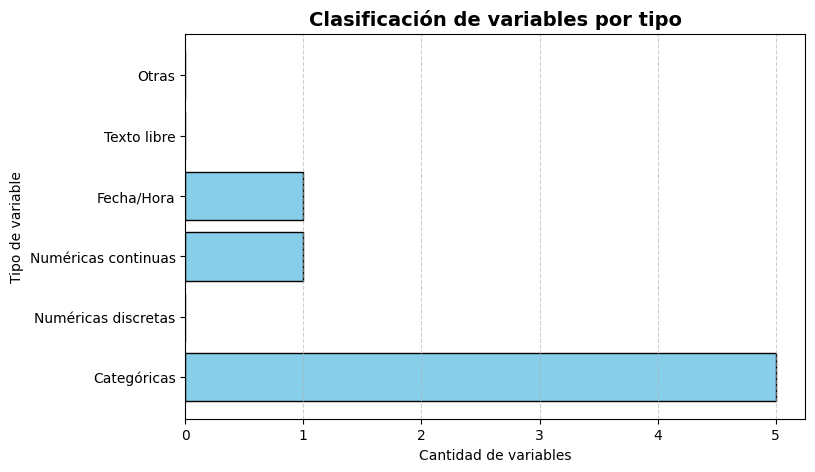

In [12]:
# --- Resultados ---
counts = {
    'Categóricas': len(categorical_vars),
    'Numéricas discretas': len(numeric_discrete_vars),
    'Numéricas continuas': len(numeric_continuous_vars),
    'Fecha/Hora': len(datetime_vars),
    'Texto libre': len(text_vars),
    'Otras': len(other_vars)
}

# --- 📊 Gráfico ---
plt.figure(figsize=(8,5))
plt.barh(list(counts.keys()), list(counts.values()), color='skyblue', edgecolor='black')
plt.title('Clasificación de variables por tipo', fontsize=14, fontweight='bold')
plt.xlabel('Cantidad de variables')
plt.ylabel('Tipo de variable')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [13]:
data.shape

(79490, 7)

In [14]:
categorical_vars

['Computer', 'Level', 'ProviderName', 'Message', 'OriginTable']

In [15]:
d=data['ProviderName'].value_counts()
d

ProviderName
Microsoft-Windows-Security-Auditing    13163
Service Control Manager                 2640
Microsoft-Windows-Kernel-Power          2606
EventLog                                2581
NotificationProcessor_REST_API           452
                                       ...  
PaymentManager_SOAP_WebService            54
AnalyticsService_SOAP_WebService          54
NotificationAPI_Microservice              54
PaymentManager_Message_Queue              54
UserHandler_Microservice                  54
Name: count, Length: 462, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

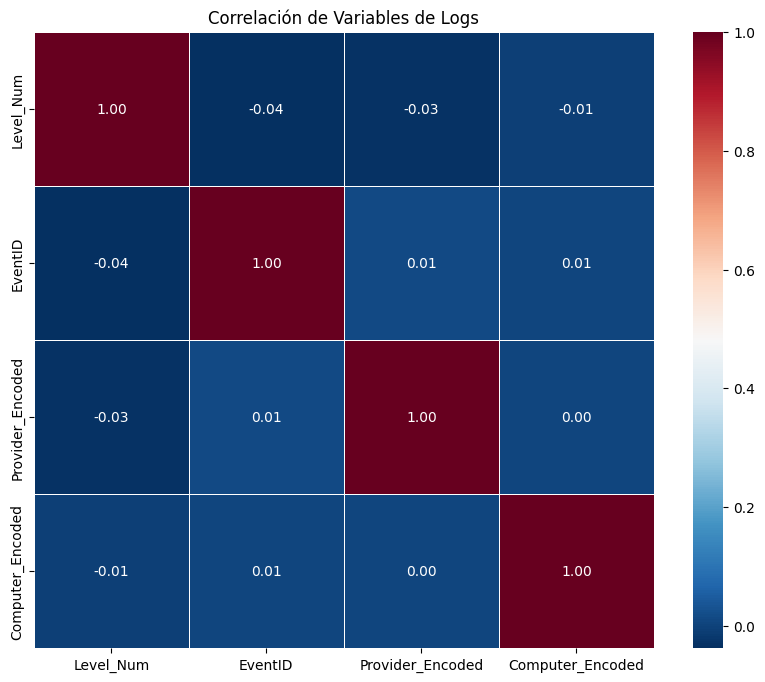

In [21]:
# 1. Crear una copia de los datos para análisis
df_corr = data.copy()

# 2. Convertir 'Level' a Numérico (Paso Crítico según el TFM)
# Asignamos: 1=Critical, 2=Error, 3=Warning, 4=Information
level_map = {
    'Critical': 1, 'Error': 2, 'Warning': 3, 'Information': 4,
    '1': 1, '2': 2, '3': 3, '4': 4  # Por seguridad si vienen como string numérico
}
df_corr['Level_Num'] = df_corr['Level'].map(level_map)

# Verificar si hay nulos tras el mapeo y eliminarlos (limpieza)
df_corr = df_corr.dropna(subset=['Level_Num'])

# 3. Convertir otras columnas de texto (Provider y Computer) a códigos numéricos
# Esto permite ver si cierto Servidor o Proveedor se correlaciona con la severidad
df_corr['Provider_Encoded'] = df_corr['ProviderName'].astype('category').cat.codes
df_corr['Computer_Encoded'] = df_corr['Computer'].astype('category').cat.codes

# 4. Seleccionar columnas para la correlación
columnas_interes = ['Level_Num', 'EventID', 'Provider_Encoded', 'Computer_Encoded']
matriz_corr = df_corr[columnas_interes].corr()

# 5. Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, 
            annot=True,       # Muestra el valor exacto en cada celda
            cmap='RdBu_r',    # Rojo = correlación positiva, Azul = negativa
            fmt=".2f",
            linewidths=0.5)
plt.title('Correlación de Variables de Logs')
plt.show()

In [22]:
# Normalizar texto de Level (quitar espacios, etc.)
df['Level'] = df['Level'].astype(str).str.strip()
df['Level_Num'] = df['Level'].map(level_map)

# Eliminar filas que no se pudieron mapear (nulos en Level_Num)
df = df.dropna(subset=['Level_Num'])
df['Level_Num'] = df['Level_Num'].astype(int)

# B. Limpieza de Texto (Message)
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Solo alfanuméricos
    return text

df['Message_Clean'] = df['Message'].apply(clean_text)

# C. Manejo de Nulos en otras columnas
df['EventID'] = df['EventID'].fillna(-1)
df['ProviderName'] = df['ProviderName'].fillna('Unknown')

# ==========================================
# 4. INGENIERÍA DE CARACTERÍSTICAS (FEATURES)
# ==========================================
print("Generando características para el modelo...")

# A. Codificación de ProviderName (Categórica -> Numérica)
le_provider = LabelEncoder()
df['Provider_Encoded'] = le_provider.fit_transform(df['ProviderName'].astype(str))

# B. Vectorización de Texto (TF-IDF)
# Usamos max_features=1000 para balancear rendimiento y memoria
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
text_features = tfidf.fit_transform(df['Message_Clean']).toarray()

# C. Consolidación de Matriz de Entrenamiento (X)
# Variables: Provider_Encoded + EventID + Texto Vectorizado
numerical_features = df[['Provider_Encoded', 'EventID']].values
X = np.hstack((numerical_features, text_features))

# Variable Objetivo (y)
y = df['Level_Num'].values

Generando características para el modelo...


In [23]:


# Definición del Espacio de Búsqueda (Según TFM Tabla 9)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300, 500],  # Número de árboles
    'max_depth': [10, 20, 30, 50, None],            # Profundidad máxima
    'min_samples_split': [2, 5, 10, 20],            # Mínimo para dividir nodo
    'min_samples_leaf': [1, 2, 4],                  # Mínimo en hojas
    'criterion': ['gini', 'entropy']                # Criterio de pureza
}

print(f"Total de combinaciones a probar: {6 * 5 * 4 * 3 * 2} configuraciones.")

Total de combinaciones a probar: 720 configuraciones.


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Set de Entrenamiento: {X_train.shape[0]} registros")
print(f"Set de Prueba: {X_test.shape[0]} registros")

Set de Entrenamiento: 63592 registros
Set de Prueba: 15898 registros


In [25]:
# Configuración del modelo base (sin hiperparámetros fijos, solo la semilla)
rf_base = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',  # Mantenemos el balanceo de clases
    n_jobs=-1                 # Usar todos los procesadores
)

# Configuración de la Búsqueda en Rejilla
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                     # El TFM usó 10, pero 5 es más rápido para pruebas
    scoring='f1_weighted',    # Métrica clave para desbalance
    verbose=2,                # Para ver el progreso en tiempo real
    n_jobs=-1                 # Paralelizar la búsqueda
)

In [26]:
print("Iniciando búsqueda de hiperparámetros... (Ve por un café ☕)")

# Entrenamos con los datos de entrenamiento (X_train, y_train)
grid_search.fit(X_train, y_train)

print("¡Búsqueda completada!")

Iniciando búsqueda de hiperparámetros... (Ve por un café ☕)
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


/opt/conda/envs/tensorflow/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/conda/envs/tensorflow/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/conda/envs/tensorflow/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin t

[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   5.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  10.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.2s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_sa

In [27]:
# Resultados
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\n--- MEJORES HIPERPARÁMETROS ENCONTRADOS ---")
print(best_params)
print(f"\nMejor F1-Score (Validación Cruzada): {best_score:.4f}")

# Guardar el mejor modelo automáticamente
best_rf_model = grid_search.best_estimator_

# (Opcional) Validar este mejor modelo contra el set de prueba final
print("\n--- Validación Final con el Mejor Modelo ---")
y_pred_opt = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_opt))


--- MEJORES HIPERPARÁMETROS ENCONTRADOS ---
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Mejor F1-Score (Validación Cruzada): 1.0000

--- Validación Final con el Mejor Modelo ---
              precision    recall  f1-score   support

           2       1.00      1.00      1.00      2692
           3       1.00      1.00      1.00      2802
           4       1.00      1.00      1.00     10404

    accuracy                           1.00     15898
   macro avg       1.00      1.00      1.00     15898
weighted avg       1.00      1.00      1.00     15898



In [30]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import RocCurveDisplay, roc_curve, auc

# Pero learning_curve y validation_curve están en model_selection
from sklearn.model_selection import TimeSeriesSplit, learning_curve, validation_curve
from sklearn.preprocessing import label_binarize

In [32]:
df_sorted = df.sort_values(by='TimeCreated')

In [33]:
X_sorted = np.hstack((
    le_provider.transform(df_sorted['ProviderName'].astype(str)).reshape(-1,1),
    df_sorted['EventID'].fillna(-1).values.reshape(-1,1),
    tfidf.transform(df_sorted['Message_Clean']).toarray()
))
y_sorted = df_sorted['Level_Num'].values

tscv = TimeSeriesSplit(n_splits=5)

In [34]:
for i, (train_index, test_index) in enumerate(tscv.split(X_sorted)):
    X_train_t, X_test_t = X_sorted[train_index], X_sorted[test_index]
    y_train_t, y_test_t = y_sorted[train_index], y_sorted[test_index]
    
    # Entrenar de nuevo en esta ventana de tiempo
    best_rf_model.fit(X_train_t, y_train_t)
    score = best_rf_model.score(X_test_t, y_test_t)
    print(f"Periodo {i+1}: Accuracy = {score:.4f} (Entreno con {len(train_index)} logs, Pruebo con {len(test_index)})")

Periodo 1: Accuracy = 1.0000 (Entreno con 13250 logs, Pruebo con 13248)
Periodo 2: Accuracy = 1.0000 (Entreno con 26498 logs, Pruebo con 13248)
Periodo 3: Accuracy = 1.0000 (Entreno con 39746 logs, Pruebo con 13248)
Periodo 4: Accuracy = 1.0000 (Entreno con 52994 logs, Pruebo con 13248)
Periodo 5: Accuracy = 1.0000 (Entreno con 66242 logs, Pruebo con 13248)


/opt/conda/envs/tensorflow/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/conda/envs/tensorflow/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/conda/envs/tensorflow/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin t

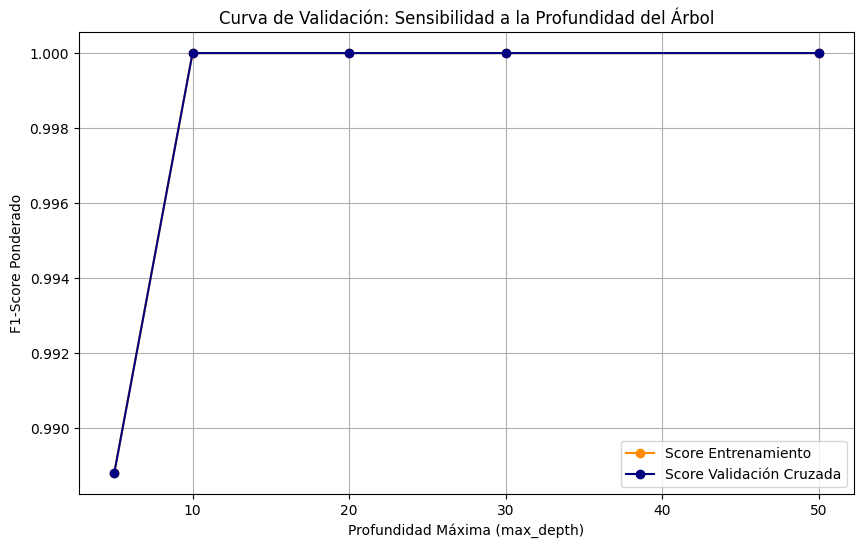

In [35]:
param_range = [5, 10, 20, 30, 50]

train_scores, test_scores = validation_curve(
    best_rf_model, X_train, y_train, 
    param_name="max_depth", 
    param_range=param_range,
    scoring="f1_weighted", 
    cv=3, 
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Score Entrenamiento", color="darkorange", marker='o')
plt.plot(param_range, test_mean, label="Score Validación Cruzada", color="navy", marker='o')
plt.title("Curva de Validación: Sensibilidad a la Profundidad del Árbol")
plt.xlabel("Profundidad Máxima (max_depth)")
plt.ylabel("F1-Score Ponderado")
plt.legend(loc="best")
plt.grid(True)
plt.show()